# Úkol č. 1 - předzpracování dat a binární klasifikace

* Termíny jsou uvedeny na [courses.fit.cvut.cz](https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html).
* Pokud odevzdáte úkol po prvním termínu ale před nejzašším termínem, budete penalizování -12 body, pozdější odevzdání je bez bodu.
* V rámci tohoto úkolu se musíte vypořádat s klasifikační úlohou s příznaky různých typů.
* Před tím, než na nich postavíte predikční model, je třeba je nějakým způsobem převést do číselné reprezentace.
    
> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budeme strhávat body.

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máte trénovací data v souboru `data.csv` a data na vyhodnocení v souboru `evaluation.csv`.

#### Seznam příznaků:
* survived - zda pasažér přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**, kterou chcete predikovat
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **25 bodů**: 
  * V notebooku načtěte data ze souboru `data.csv`. Vhodným způsobem si je rozdělte na podmnožiny, které Vám poslouží pro trénování (trénovací), porovnávání modelů (validační) a následnou predikci výkonnosti finálního modelu (testovací).
    
  * Proveďte základní předzpracování dat:
    * Projděte si jednotlivé příznaky a transformujte je do vhodné podoby pro použití ve vybraném klasifikačním modelu.
    * Podle potřeby si můžete vytvářet nové příznaky (na základě existujících), například tedy můžete vytvořit příznak měřící délku jména atp.
    * Některé příznaky můžete také úplně zahodit.
    * Nějakým způsobem se vypořádejte s chybějícími hodnotami. _Pozor na metodické chyby!_
    * Můžete využívat i vizualizace a vše stručně ale náležitě komentujte.

  
  * Na připravená data postupně aplikujte **rozhodovací strom** a **metodu nejbližších sousedů**, přičemž pro každý z těchto modelů:
    * Okomentujte vhodnost daného modelu pro daný typ úlohy.
    * Vyberte si hlavní hyperparametry k ladění a najděte jejich nejlepší hodnoty.
    * Pro model s nejlepšími hodnotami hyperparametrů spočtěte F1 skóre, nakreslete ROC křivku a určete AUC. _Pozor na metodické chyby!_
    * Získané výsledky vždy řádně okomentujte.

        
  * Ze všech zkoušených možností v předchozím kroku vyberte finální model a odhadněte, jakou přesnost můžete očekávat na nových datech, která jste doposud neměli k dispozici. _Pozor na metodické chyby!_
    
  * Nakonec načtěte vyhodnocovací data ze souboru`evaluation.csv`. Pomocí finálního modelu napočítejte predikce pro tyto data (vysvětlovaná proměnná v nich již není). Vytvořte soubor `results.csv`, ve kterém získané predikce uložíte do dvou sloupců: **ID**, **survived**. Tento soubor též odevzdejte (uložte do repozitáře vedle notebooku).

  * Ukázka prvních řádků souboru `results.csv`:
  
```
ID,survived
1000,0
1001,1
...
```

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html.

# 0. Importy, příprava prostředí

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype

import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import plot_tree

import sklearn.metrics as metrics

random_seed = 42

# 1. Přezpracování dat

In [2]:
df_data = pd.read_csv("data.csv")

Nejprve si data vycistime a prevedeme na ciselne hodnoty

Pak rozdelime si nejprve data na casti
- promichame data
- rozdelime na train, val, test

## First Look

In [3]:
df_orig = pd.read_csv("data.csv")

In [4]:
df_data.head(3)

,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.90,NaN,S,"Wiltshire, England Niagara Falls, NY"
1,1,0,3,"Jardin, Mr. Jose Neto",male,NaN,0,0,SOTON/O.Q. 3101305,7.05,NaN,S,NaN
2,2,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.90,NaN,S,NaN


In [5]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   survived   1000 non-null   int64  
 2   pclass     1000 non-null   int64  
 3   name       1000 non-null   object 
 4   sex        1000 non-null   object 
 5   age        802 non-null    float64
 6   sibsp      1000 non-null   int64  
 7   parch      1000 non-null   int64  
 8   ticket     1000 non-null   object 
 9   fare       999 non-null    float64
 10  cabin      233 non-null    object 
 11  embarked   998 non-null    object 
 12  home.dest  566 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 101.7+ KB


In [6]:
df_data.select_dtypes(include=['int', 'float']).describe()

,ID,survived,pclass,age,sibsp,parch,fare
count,1000.000000,1000.00000,1000.000000,802.000000,1000.000000,1000.00000,999.000000
mean,499.500000,0.39800,2.288000,29.850686,0.496000,0.40200,34.264352
std,288.819436,0.48973,0.840096,14.328743,1.024223,0.91719,53.315077
min,0.000000,0.00000,1.000000,0.166700,0.000000,0.00000,0.000000
25%,249.750000,0.00000,1.750000,21.000000,0.000000,0.00000,7.925000
50%,499.500000,0.00000,3.000000,28.000000,0.000000,0.00000,14.458300
75%,749.250000,1.00000,3.000000,39.000000,1.000000,0.00000,31.275000
max,999.000000,1.00000,3.000000,80.000000,8.000000,9.00000,512.329200


In [7]:
df_data.select_dtypes(include=['object']).describe()

,name,sex,ticket,cabin,embarked,home.dest
count,1000,1000,1000,233,998,566
unique,999,2,746,157,3,313
top,"Kelly, Mr. James",male,CA. 2343,B57 B59 B63 B66,S,"New York, NY"
freq,2,628,9,5,698,46


In [8]:
df_data.nunique()

ID           1000
survived        2
pclass          3
name          999
sex             2
age            95
sibsp           7
parch           8
ticket        746
fare          254
cabin         157
embarked        3
home.dest     313
dtype: int64

In [9]:
df_data.isna().any()

ID           False
survived     False
pclass       False
name         False
sex          False
age           True
sibsp        False
parch        False
ticket       False
fare          True
cabin         True
embarked      True
home.dest     True
dtype: bool

## Columns

### ID Column
***

In [10]:
# jak vidime, ID neni potreba, protoze sloupec ID je stejny jako index dataframu - proste to odstranime, neni to fakt potreba
(df_data['ID'] == df_data.index).sum() == len(df_data)

True

In [11]:
df_data.drop(columns=['ID'], inplace=True)

In [12]:
df_data

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9000,NaN,S,"Wiltshire, England Niagara Falls, NY"
1,0,3,"Jardin, Mr. Jose Neto",male,NaN,0,0,SOTON/O.Q. 3101305,7.0500,NaN,S,NaN
2,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9000,NaN,S,NaN
3,1,3,"O'Brien, Mrs. Thomas (Johanna ""Hannah"" Godfrey)",female,NaN,1,0,370365,15.5000,NaN,Q,NaN
4,1,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,"Greensburg, PA"
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,2,"Greenberg, Mr. Samuel",male,52.0,0,0,250647,13.0000,NaN,S,"Bronx, NY"
996,0,2,"Coleridge, Mr. Reginald Charles",male,29.0,0,0,W./C. 14263,10.5000,NaN,S,"Hartford, Huntingdonshire"
997,0,1,"Smart, Mr. John Montgomery",male,56.0,0,0,113792,26.5500,NaN,S,"New York, NY"
998,1,1,"Harder, Mr. George Achilles",male,25.0,1,0,11765,55.4417,E50,C,"Brooklyn, NY"


### Survived
***

Tento sloupec je v poradku, nabyva pouze hodnot 0 a 1 - true nebo false, datovy typ je v poradku

In [13]:
df_data['survived'].unique()

array([0, 1])

### Pclass
***

In [14]:
df_data['pclass'].unique()

array([3, 2, 1])

- Nema chybejici hodnoty
- unikatniv hodnoty jsou 3, 2 ,1
- je numericky - pohoda

Prevedem na kategoricky priznak
Pritom ma smysl udelat to jako ordered - protoze serazeni tady muze hrat dulezitou roli

1. class - nejlepsi, 2. je horsi, 3. je nejhorsi, plati 1 > 2 > 3

In [15]:
cat_pclass = CategoricalDtype(categories=[3, 2, 1], ordered=True)
df_data['pclass'] = df_data['pclass'].astype(cat_pclass)

 

In [16]:
display(df_data['pclass'].sample(5))

605    2
438    3
721    3
884    3
8      2
Name: pclass, dtype: category
Categories (3, int64): [3 < 2 < 1]

In [17]:
df_data['pclass']

0      3
1      3
2      3
3      3
4      3
      ..
995    2
996    2
997    1
998    1
999    3
Name: pclass, Length: 1000, dtype: category
Categories (3, int64): [3 < 2 < 1]

In [18]:
df_data['pclass'].cat.codes

0      0
1      0
2      0
3      0
4      0
      ..
995    1
996    1
997    2
998    2
999    0
Length: 1000, dtype: int8

Je videt, ze skutecne to proste nahradilo 3 za 0, tak ze tam plati velmi basic usporadani

### Name
***

- Doesn't have nulls
- has 999 unique, so one of them is not unique

In [19]:
df_data[df_data['name'] == 'Kelly, Mr. James']

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
651,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,NaN
964,0,3,"Kelly, Mr. James",male,44.0,0,0,363592,8.0500,NaN,S,NaN


We have two passengers, that are different, but with same names. Interesting

In [20]:
df_data['name'].sample(5)

291                     Johnson, Miss. Eleanor Ileen
581                                Karaic, Mr. Milan
286                               Cacic, Miss. Manda
305                                Balkic, Mr. Cerin
816    Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)
Name: name, dtype: object

In [21]:
df_data.loc[212]

survived                                                1
pclass                                                  1
name         Widener, Mrs. George Dunton (Eleanor Elkins)
sex                                                female
age                                                  50.0
sibsp                                                   1
parch                                                   1
ticket                                             113503
fare                                                211.5
cabin                                                 C80
embarked                                                C
home.dest                                 Elkins Park, PA
Name: 212, dtype: object

In [22]:
df_data[df_data['name'].str.contains('Widener')]

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
212,1,1,"Widener, Mrs. George Dunton (Eleanor Elkins)",female,50.0,1,1,113503,211.5,C80,C,"Elkins Park, PA"
866,0,1,"Widener, Mr. George Dunton",male,50.0,1,1,113503,211.5,C80,C,"Elkins Park, PA"


Apparently, we can infer who was with who, but it will take some time

Now, let's just drop name column, becaues as it is it doesn't represent much, every value is unique

In [23]:
df_data.drop(columns=['name'], inplace=True)

In [24]:
df_data

,survived,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,3,male,11.0,5,2,CA 2144,46.9000,NaN,S,"Wiltshire, England Niagara Falls, NY"
1,0,3,male,NaN,0,0,SOTON/O.Q. 3101305,7.0500,NaN,S,NaN
2,0,3,male,4.0,3,2,347088,27.9000,NaN,S,NaN
3,1,3,female,NaN,1,0,370365,15.5000,NaN,Q,NaN
4,1,3,female,18.0,0,0,2657,7.2292,NaN,C,"Greensburg, PA"
...,...,...,...,...,...,...,...,...,...,...,...
995,0,2,male,52.0,0,0,250647,13.0000,NaN,S,"Bronx, NY"
996,0,2,male,29.0,0,0,W./C. 14263,10.5000,NaN,S,"Hartford, Huntingdonshire"
997,0,1,male,56.0,0,0,113792,26.5500,NaN,S,"New York, NY"
998,1,1,male,25.0,1,0,11765,55.4417,E50,C,"Brooklyn, NY"


### Sex
***

- no null rows
- only two uniqe values - male/female

What we can do is to set it as categorical, where 0 is for male and 1 is for female

In [25]:
df_data['sex'] = df_data['sex'].astype('category')
df_data['sex']

0        male
1        male
2        male
3      female
4      female
        ...  
995      male
996      male
997      male
998      male
999    female
Name: sex, Length: 1000, dtype: category
Categories (2, object): ['female', 'male']

In [26]:
df_data['sex'].cat.codes

0      1
1      1
2      1
3      0
4      0
      ..
995    1
996    1
997    1
998    1
999    0
Length: 1000, dtype: int8

### Age
***

- numeric 
- **has some null rows** 
- **95** unique 

In [27]:
df_data['age'].describe()

count    802.000000
mean      29.850686
std       14.328743
min        0.166700
25%       21.000000
50%       28.000000
75%       39.000000
max       80.000000
Name: age, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7f686b1ba950>,
 'caps': [<matplotlib.lines.Line2D at 0x7f686af3e9d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f686af3cc50>],
 'medians': [<matplotlib.lines.Line2D at 0x7f686af3fb50>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f686af50490>],
 'means': []}

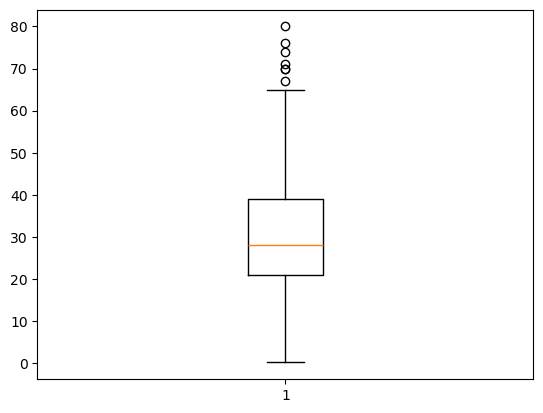

In [28]:
fig, ax = plt.subplots()
ax.boxplot(x=df_data['age'].dropna())

There are two ways:
- remove outliers and add mean to nans
- leave outliers as they are and impute medians, which
- also we could look into data more thoroughly, for example to find someone's wifes and children, so we can impute their ages much more precisely and this will lead to better data for learning

Later we could write 2 functions for the first and the second variant, and even for the 3. situation, but now lets use the 2. variant

In [29]:
df_data['age'].median()

28.0

In pandas, median ignores nan values

In [30]:
(df_data['age'].median() == df_data['age'].dropna().median()) and df_data['age'].isna().any()

True

In [31]:
df_data.loc[df_data['age'].isna(), 'age'] = df_data['age'].median()

In [32]:
df_data

,survived,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,3,male,11.0,5,2,CA 2144,46.9000,NaN,S,"Wiltshire, England Niagara Falls, NY"
1,0,3,male,28.0,0,0,SOTON/O.Q. 3101305,7.0500,NaN,S,NaN
2,0,3,male,4.0,3,2,347088,27.9000,NaN,S,NaN
3,1,3,female,28.0,1,0,370365,15.5000,NaN,Q,NaN
4,1,3,female,18.0,0,0,2657,7.2292,NaN,C,"Greensburg, PA"
...,...,...,...,...,...,...,...,...,...,...,...
995,0,2,male,52.0,0,0,250647,13.0000,NaN,S,"Bronx, NY"
996,0,2,male,29.0,0,0,W./C. 14263,10.5000,NaN,S,"Hartford, Huntingdonshire"
997,0,1,male,56.0,0,0,113792,26.5500,NaN,S,"New York, NY"
998,1,1,male,25.0,1,0,11765,55.4417,E50,C,"Brooklyn, NY"


### Sibsp
***

- doesn't have missing values
- is integer
- min is 0, max is 8
- order make sense, so we just leave it as it is
- next idea is to pair survivability of siblings and spouses - probably relative will have survival in groups better (adding new feature which reflects if sibling or spouse survived too)

The only problem is that we don't know who are those sibsp - siblings/spouses - it will be very good to divide it later

{'whiskers': [<matplotlib.lines.Line2D at 0x7f6862db6910>,
 'caps': [<matplotlib.lines.Line2D at 0x7f6862dc0210>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f6862db5e50>],
 'medians': [<matplotlib.lines.Line2D at 0x7f6862dc1850>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f6862dc23d0>],
 'means': []}

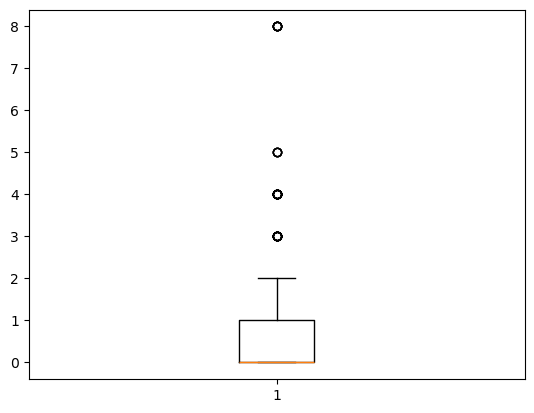

In [33]:
fig, ax = plt.subplots()
ax.boxplot(x=df_data['sibsp'])

Here we have pretty strong outliers...

In [34]:
df_data['sibsp'].value_counts().sort_index()

sibsp
0    674
1    253
2     34
3     13
4     15
5      4
8      7
Name: count, dtype: int64

### Parch
***

parch - parent/children - this can be divided by age
- we can look at ages and follow the parent/children value, when it sorts of flips
- after that we can by name pair children to their parents
- also we could add new feature - is children or is not children (though this information will be already in age somehow built)

- no null rows
- integer

In [35]:
df_data['parch'].unique()

array([2, 0, 1, 3, 5, 6, 4, 9])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f6862e29590>,
 'caps': [<matplotlib.lines.Line2D at 0x7f6862e2ad90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f686afc1f90>],
 'medians': [<matplotlib.lines.Line2D at 0x7f6862e38390>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f6862e38e50>],
 'means': []}

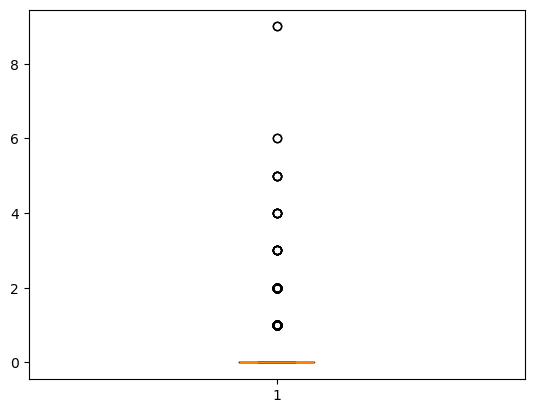

In [36]:
fig, ax = plt.subplots()
ax.boxplot(x=df_data['parch'])

In [37]:
df_data['parch'].value_counts().sort_index()

parch
0    766
1    123
2     88
3      8
4      6
5      5
6      2
9      2
Name: count, dtype: int64

### ticket
***

- We have 746 unique ticket values
- no null rows

In [38]:
df_data['ticket']

0                 CA 2144
1      SOTON/O.Q. 3101305
2                  347088
3                  370365
4                    2657
              ...        
995                250647
996           W./C. 14263
997                113792
998                 11765
999                343095
Name: ticket, Length: 1000, dtype: object

We can see, that some passengers have same tickets.. Can we use this info?

In [39]:
df_data[df_data['ticket'].duplicated()]

,survived,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
113,0,2,female,57.0,0,0,S.O./P.P. 3,10.5000,E77,S,"Southampton / New York, NY"
116,1,2,female,34.0,1,1,28220,32.5000,NaN,S,"Greenport, NY"
139,0,3,female,14.5,1,0,2665,14.4542,NaN,C,NaN
149,0,1,male,23.0,0,0,12749,93.5000,B24,S,"Montreal, PQ"
154,0,3,male,34.0,1,1,347080,14.4000,NaN,S,"Stanton, IA"
...,...,...,...,...,...,...,...,...,...,...,...
989,1,1,female,63.0,1,0,13502,77.9583,D7,S,"Hudson, NY"
991,0,3,male,9.0,5,2,CA 2144,46.9000,NaN,S,"Wiltshire, England Niagara Falls, NY"
994,1,3,male,3.0,4,2,347077,31.3875,NaN,S,"Sweden Worcester, MA"
995,0,2,male,52.0,0,0,250647,13.0000,NaN,S,"Bronx, NY"


In [40]:
df_orig[df_data['ticket'] == '28220']

,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
10,10,1,2,"Drew, Master. Marshall Brines",male,8.0,0,2,28220,32.5,NaN,S,"Greenport, NY"
116,116,1,2,"Drew, Mrs. James Vivian (Lulu Thorne Christian)",female,34.0,1,1,28220,32.5,NaN,S,"Greenport, NY"
762,762,0,2,"Drew, Mr. James Vivian",male,42.0,1,1,28220,32.5,NaN,S,"Greenport, NY"


For example we can see, that they don't have cabin. But clearly they are from the same family. This is another way how to find families

In [41]:
df_orig[df_data['ticket'].str.endswith('2144')]

,ID,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,0,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9,NaN,S,"Wiltshire, England Niagara Falls, NY"
244,244,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.9,NaN,S,"Wiltshire, England Niagara Falls, NY"
281,281,0,3,"Goodwin, Mr. Charles Frederick",male,40.0,1,6,CA 2144,46.9,NaN,S,"Wiltshire, England Niagara Falls, NY"
374,374,0,3,"Goodwin, Mrs. Frederick (Augusta Tyler)",female,43.0,1,6,CA 2144,46.9,NaN,S,"Wiltshire, England Niagara Falls, NY"
645,645,0,3,"Goodwin, Mr. Charles Edward",male,14.0,5,2,CA 2144,46.9,NaN,S,"Wiltshire, England Niagara Falls, NY"
991,991,0,3,"Goodwin, Master. Harold Victor",male,9.0,5,2,CA 2144,46.9,NaN,S,"Wiltshire, England Niagara Falls, NY"


Again, same ticket - we see, that this is the same family, but cabin number is empty
This will be a very good way to find families
For example we could even add new feature - family id. Though for learning this will be a very bad feature

For our data analysis, we will of course drop the ticket feature, because we cannot use it.

In [42]:
df_data.drop(columns=['ticket'], inplace=True)

In [43]:
df_data

,survived,pclass,sex,age,sibsp,parch,fare,cabin,embarked,home.dest
0,0,3,male,11.0,5,2,46.9000,NaN,S,"Wiltshire, England Niagara Falls, NY"
1,0,3,male,28.0,0,0,7.0500,NaN,S,NaN
2,0,3,male,4.0,3,2,27.9000,NaN,S,NaN
3,1,3,female,28.0,1,0,15.5000,NaN,Q,NaN
4,1,3,female,18.0,0,0,7.2292,NaN,C,"Greensburg, PA"
...,...,...,...,...,...,...,...,...,...,...
995,0,2,male,52.0,0,0,13.0000,NaN,S,"Bronx, NY"
996,0,2,male,29.0,0,0,10.5000,NaN,S,"Hartford, Huntingdonshire"
997,0,1,male,56.0,0,0,26.5500,NaN,S,"New York, NY"
998,1,1,male,25.0,1,0,55.4417,E50,C,"Brooklyn, NY"


### fare
***

- only one value is null - can be inferred from the mean or class - if we will group fares by class and calculate the medin from the appropriate class

In [44]:
df_data['fare']

0      46.9000
1       7.0500
2      27.9000
3      15.5000
4       7.2292
        ...   
995    13.0000
996    10.5000
997    26.5500
998    55.4417
999     8.0500
Name: fare, Length: 1000, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7f6862cdea50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f6862ce4210>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f6862cde050>],
 'medians': [<matplotlib.lines.Line2D at 0x7f6862ce5990>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f6862ce6450>],
 'means': []}

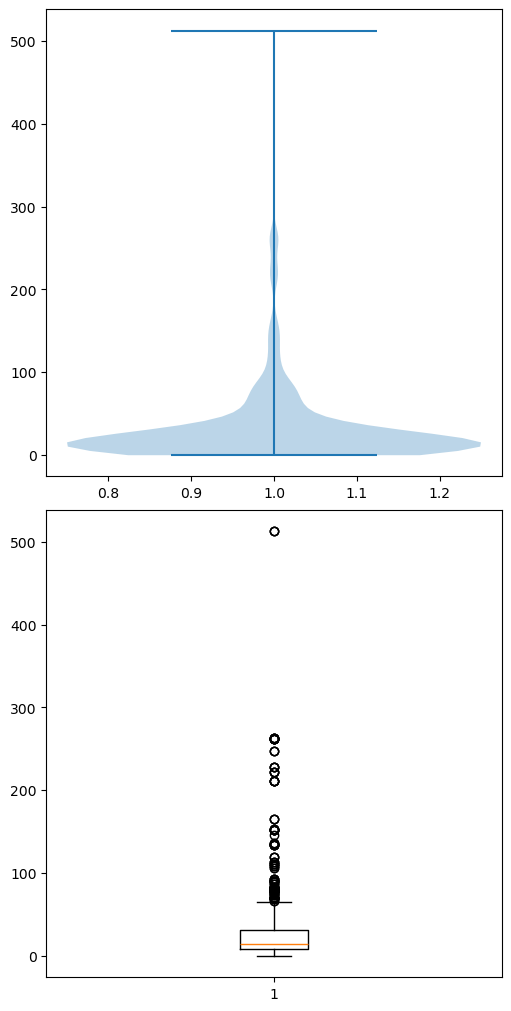

In [45]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, constrained_layout=True, figsize=(5,10))
ax1.violinplot(df_data['fare'].dropna())
ax2.boxplot(df_data['fare'].dropna())

- We can see that there too many outliers... Especially the 500 ticket value.. This is clearly the mistake... We should see if it mathces the class, or there was just one zero more and in reality it is 500. The right solution can be impute with medians of appropriate classes

- it is very important to understand, how outliers affect kNN and DT - and probably construct different algos or columns for those two algos. 

For now, we will just put median value to the missing

In [46]:
df_data.loc[df_data['fare'].isna(),'fare'] = df_data['fare'].median()

### cabin
***

- string type
- has null values - and has so many null rows.. 

In [47]:
df_data['cabin'].unique()

array([nan, 'B30', 'C49', 'C83', 'F4', 'C99', 'C62 C64',
       'B57 B59 B63 B66', 'B102', 'B58 B60', 'B5', 'D20', 'D40', 'B101',
       'B37', 'F E57', 'C78', 'E121', 'B41', 'C116', 'E58', 'C124', 'D15',
       'E77', 'B69', 'E101', 'C52', 'C92', 'D19', 'C23 C25 C27', 'D17',
       'B24', 'B96 B98', 'B22', 'D', 'B50', 'C22 C26', 'B45', 'C103',
       'D46', 'B39', 'B35', 'E25', 'C65', 'F38', 'A24', 'C47', 'C91',
       'C7', 'F2', 'E24', 'C80', 'A6', 'C148', 'C106', 'E12', 'C54',
       'D30', 'B73', 'D28', 'C123', 'C51', 'E63', 'A19', 'F G63', 'E46',
       'C46', 'C126', 'B49', 'D37', 'E36', 'B18', 'D26', 'B77', 'A11',
       'A34', 'A20', 'B79', 'E44', 'C93', 'D33', 'F33', 'A5', 'D36',
       'C32', 'B28', 'C89', 'C39', 'C30', 'C101', 'B71', 'E10', 'E33',
       'D11', 'C55 C57', 'F E69', 'B10', 'B51 B53 B55', 'B4', 'E52', 'F',
       'E34', 'E67', 'A31', 'D50', 'E60', 'A18', 'G6', 'D48', 'C132',
       'A7', 'C68', 'A36', 'D56', 'A23', 'C2', 'C105', 'D22', 'D35',
       'B78', 'D3

has some duplicates - which is not suprising, because families could live in same cabin

There are letters infront of numbers - this could be a signal for us, that it can correlate with some classes

- idea is to infer what those letters mean, understand how they correlate with classes and fares
- from this we can also infer the of the letter other passengers could have.
- but be careful to not create data from nothing - if it correlates with other features, this feature can be just useless

For now we will just drop this column

In [48]:
df_data.drop(columns=["cabin"], inplace=True)

### embarked 
***

- there are 2 null values - not so much. We can try infer them from same family members, if there are any

In [49]:
df_data['embarked'].unique()

array(['S', 'Q', 'C', nan], dtype=object)

- we can delete this, because how the city where the person embarked on the ship can affect the chance of survival?
- draw correlation heatmap to inspect that
- or use one-hot encoding

we will fill it with the most frequent value and use one-hot encoding on this

In [50]:
most_frequent_index = df_data['embarked'].value_counts().sort_values(ascending=False).index[0]

In [51]:
df_data.loc[df_data['embarked'].isna(),'embarked'] = most_frequent_index

In [52]:
df_data['embarked'].isna().any()

False

In [53]:
df_data = pd.get_dummies(data=df_data, columns=['embarked'])

### home.dest
***

- a lot of null rows
- can be used only for imputing of other data or creating new features

For now we will just drop it

In [54]:
df_data.drop(columns=['home.dest'], inplace=True)

## Results

In [55]:
df_data

,survived,pclass,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
0,0,3,male,11.0,5,2,46.9000,False,False,True
1,0,3,male,28.0,0,0,7.0500,False,False,True
2,0,3,male,4.0,3,2,27.9000,False,False,True
3,1,3,female,28.0,1,0,15.5000,False,True,False
4,1,3,female,18.0,0,0,7.2292,True,False,False
...,...,...,...,...,...,...,...,...,...,...
995,0,2,male,52.0,0,0,13.0000,False,False,True
996,0,2,male,29.0,0,0,10.5000,False,False,True
997,0,1,male,56.0,0,0,26.5500,False,False,True
998,1,1,male,25.0,1,0,55.4417,True,False,False


In [56]:
df_data.isna().any()

survived      False
pclass        False
sex           False
age           False
sibsp         False
parch         False
fare          False
embarked_C    False
embarked_Q    False
embarked_S    False
dtype: bool

Models do not accept categorical data types, so lets just get some cat codes

In [57]:
for col in df_data.select_dtypes(['category']).columns:
    df_data[col] = df_data[col].cat.codes

In [58]:
df_data

,survived,pclass,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
0,0,0,1,11.0,5,2,46.9000,False,False,True
1,0,0,1,28.0,0,0,7.0500,False,False,True
2,0,0,1,4.0,3,2,27.9000,False,False,True
3,1,0,0,28.0,1,0,15.5000,False,True,False
4,1,0,0,18.0,0,0,7.2292,True,False,False
...,...,...,...,...,...,...,...,...,...,...
995,0,1,1,52.0,0,0,13.0000,False,False,True
996,0,1,1,29.0,0,0,10.5000,False,False,True
997,0,2,1,56.0,0,0,26.5500,False,False,True
998,1,2,1,25.0,1,0,55.4417,True,False,False


In [59]:
df_data.duplicated().sum()

140

# 2. Decision Trees

### Vhodnost DT pro dany typ ulohy

### Trenovani

Lets split data into 3 parts, usin sklearn function

In [60]:
Xtrain, Xrest, ytrain, yrest = train_test_split(
    df_data.drop(columns=["survived"]), df_data["survived"], test_size=0.4
)

Xtest, Xval, ytest, yval = train_test_split(
    Xrest, yrest, test_size=0.6
)

In [61]:
clf = DecisionTreeClassifier(max_depth=2)
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [62]:
clf.fit(Xtrain, ytrain)

DecisionTreeClassifier(max_depth=2)

[Text(0.5, 0.8333333333333334, 'sex <= 0.5\ngini = 0.481\nsamples = 600\nvalue = [359, 241]\nclass = y[0]'),
 Text(0.25, 0.5, 'pclass <= 0.5\ngini = 0.4\nsamples = 235\nvalue = [65, 170]\nclass = y[1]'),
 Text(0.125, 0.16666666666666666, 'gini = 0.499\nsamples = 109\nvalue = [57, 52]\nclass = y[0]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.119\nsamples = 126\nvalue = [8, 118]\nclass = y[1]'),
 Text(0.75, 0.5, 'pclass <= 1.5\ngini = 0.313\nsamples = 365\nvalue = [294, 71]\nclass = y[0]'),
 Text(0.625, 0.16666666666666666, 'gini = 0.243\nsamples = 290\nvalue = [249, 41]\nclass = y[0]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.48\nsamples = 75\nvalue = [45, 30]\nclass = y[0]')]

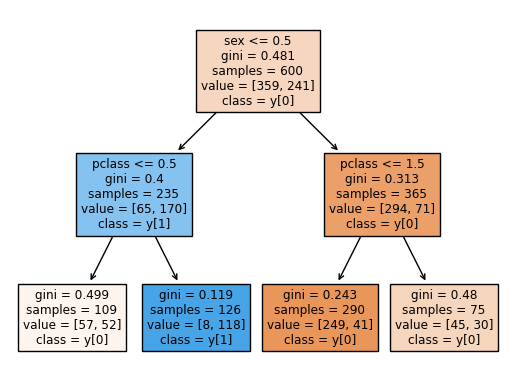

In [63]:
fig, ax = plt.subplots()
plot_tree(clf, ax=ax, filled=True, feature_names=Xtrain.columns, class_names=True)

In [64]:
ypredicted = clf.predict(Xtrain)
(ytrain - ypredicted).value_counts()

survived
 0    469
 1    123
-1      8
Name: count, dtype: int64

We can see, that there are 465 zeros - those are TP and TN - correctly predicted (1-1 or 0-0 - complete concurrence) - TN + TP

There are 125 of 1. This can be only in situation when in ytrain there is 1, and in ypredicted there is 0, so it is FN class

There are 10 of -1. This can happen only if ytrain is 0 and ypredicted is 1 - FP class

In [65]:
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, clf.predict(Xtrain))))
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(yval, clf.predict(Xval))))
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytest, clf.predict(Xtest))))

accuracy score (train): 0.781667
accuracy score (train): 0.750000
accuracy score (train): 0.768750


Now we have statistics only for one hyperparameter value - only one depth. We need though much more

In [66]:
# we can see that y[0] is 0 - not survived
clf.classes_

array([0, 1])

In [67]:
param_grid = {
    'max_depth': range(1,30),
    'criterion': ['entropy','gini']
}
param_comb = ParameterGrid(param_grid)

In [68]:
val_acc = []
train_acc = []
for params in param_comb:
    clf = DecisionTreeClassifier(**params)
    clf.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, clf.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, clf.predict(Xval)))

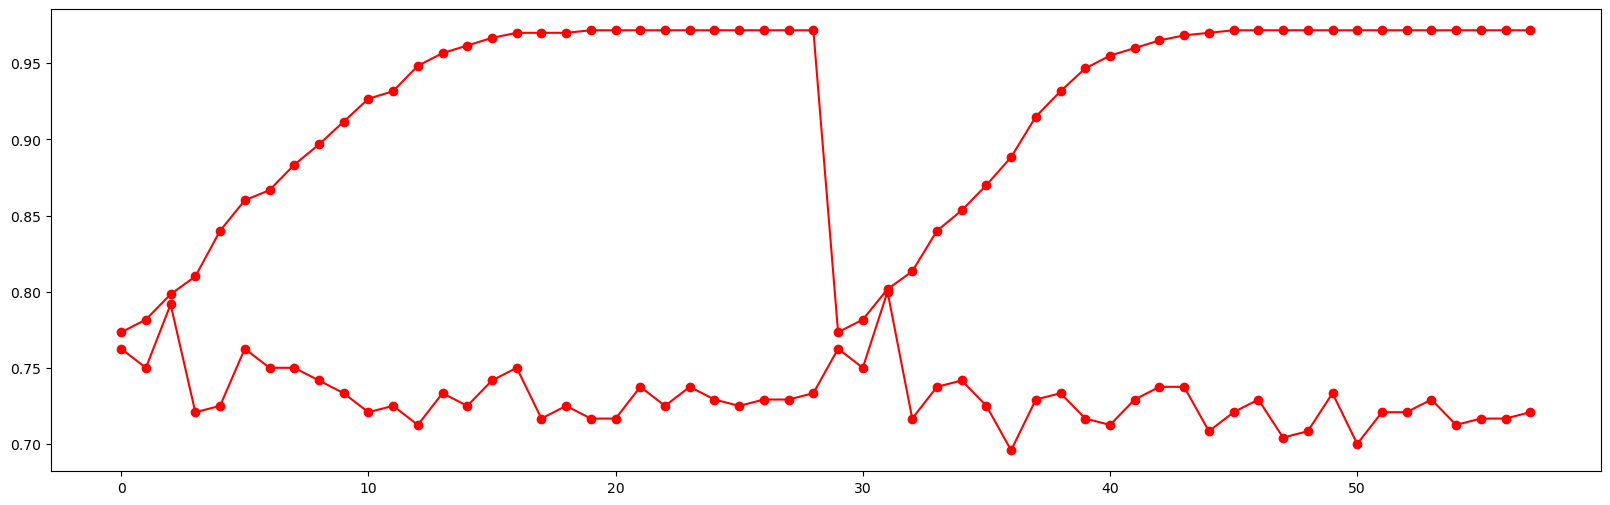

In [69]:
fig, ax = plt.subplots(figsize=(20,6))
ax.plot(train_acc, 'or-', label='train')
ax.plot(val_acc, 'or-', label='validation')

In [70]:
best_params = param_comb[np.argmax(val_acc)]
best_params

{'max_depth': 3, 'criterion': 'gini'}

In [71]:
best_clf = DecisionTreeClassifier(**best_params) 
best_clf.fit(Xtrain, ytrain)
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, best_clf.predict(Xtrain))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, best_clf.predict(Xval))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, best_clf.predict(Xtest))))

accuracy score (train): 0.801667
accuracy score (validation): 0.800000
accuracy score (test): 0.781250


My best - without proper stats

### Evaluace

In [72]:
ypred = best_clf.predict(Xtest)

In [73]:
cf = metrics.confusion_matrix(ytest, ypred)

In [74]:
display(cf)
print(f'TN: {cf[0,0]}')
print(f'FP: {cf[0,1]}')
print(f'FN: {cf[1,0]}')
print(f'TP: {cf[1,1]}')

array([[81, 15],
       [20, 44]])

TN: 81
FP: 15
FN: 20
TP: 44


In [75]:
def print_metrics(cf, ytest, ypred):
    cf_r = np.dot(np.diag(1./cf.sum(axis = 1)), cf) # rucne
    print(cf_r)
    cf_r = metrics.confusion_matrix(ytest, ypred, normalize = 'true') # knihovna
    print(cf_r)

    print(f"\nTPR = {cf_r[1,1]:.4f}\nFPR = {cf_r[0,1]:.4f}\nFNR = {cf_r[1,0]:.4f}\nTNR = {cf_r[0,0]:.4f}")
    cf_rp = metrics.confusion_matrix(ytest, ypred, normalize = 'pred')
    print(f"\nrecall = TPR = {cf_r[1,1]:.4f}, precision = {cf_rp[1,1]:.4f}")

    acc = (cf[0,0] + cf[1,1])/cf.sum()
    print(f"\naccuracy = {acc:.4f}")
    f1 = 2/(1/cf_r[1,1] + 1/cf_rp[1,1])
    print(f"f1 = {f1:.4f}")
    
    print(f'Accuracy score (test): {metrics.accuracy_score(ytest, ypred):.4f}')
    print(f'F1 score (test): {metrics.f1_score(ytest, ypred):.4f}')

In [76]:
print_metrics(cf, ytest, ypred)

[[0.84375 0.15625]
 [0.3125  0.6875 ]]
[[0.84375 0.15625]
 [0.3125  0.6875 ]]

TPR = 0.6875
FPR = 0.1562
FNR = 0.3125
TNR = 0.8438

recall = TPR = 0.6875, precision = 0.7458

accuracy = 0.7812
f1 = 0.7154
Accuracy score (test): 0.7812
F1 score (test): 0.7154


In [77]:
ypred_proba = best_clf.predict_proba(Xtest)

In [78]:
# matice - radek - predikce pro kazdy bod, sloupec - hodnot predikce
ypred_proba.shape

(160, 2)

In [79]:
p0_hat = ypred_proba[:,0]
p1_hat = ypred_proba[:,1]

In [80]:
print(p0_hat[0:5])
print(p1_hat[0:5])


[0.63380282 0.86713287 0.14       0.86713287 0.46875   ]
[0.36619718 0.13286713 0.86       0.13286713 0.53125   ]


In [81]:
fpr, tpr, thr = metrics.roc_curve(ytest, p1_hat)
auc = metrics.roc_auc_score(ytest, p1_hat)

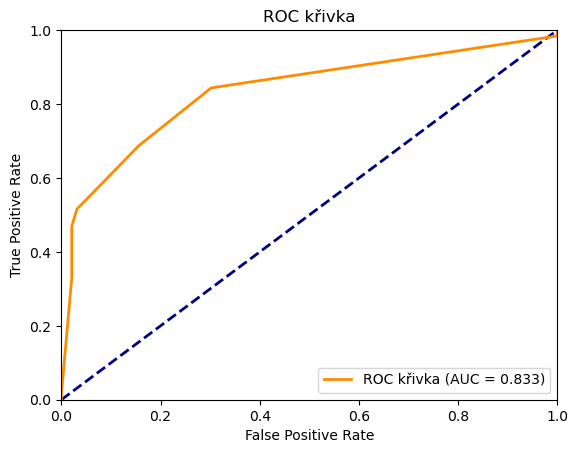

In [85]:
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
ax.plot(fpr, tpr, color="darkorange", lw=2, label = f"ROC křivka (AUC = {auc:.3f})")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC křivka")
ax.legend(loc="lower right")

Muzeme z tohoto grafu vzit bod ktery je nejblizsi ke levemu hornimu uhlu - pro tento threshold budeme mit nejlepsi kombinaci TPR a FPR - tady tedy uz zalezi co chceme - vetsi TPR anebo vetsi FPR.

# 3. kNN

Pozor na to, abys normalizoval data - metodicka chyba normalizovat cely dataset - pri normalizaci muze dojit k vyuziti dat z jine casti!!

### Vhodnost

- Mame outlieri - ty hodne ovlivnuji pri min-max normalizaci - problem

### Trenovani

In [87]:
clfKNN = KNeighborsClassifier(n_neighbors=5)
clfKNN.fit(Xtrain, ytrain)
print(f"Validation accuracy: {metrics.accuracy_score(yval, clfKNN.predict(Xval)):0.4f}")

Validation accuracy: 0.6583


In [90]:
ypred_proba_kNN = clfKNN.predict_proba(Xtest)
p1_hat = ypred_proba[:,1]

In [93]:
fpr, tpr, thr = metrics.roc_curve(y_true=ytest, y_score=p1_hat)
auc = metrics.roc_auc_score(y_true=ytest, y_score=p1_hat)

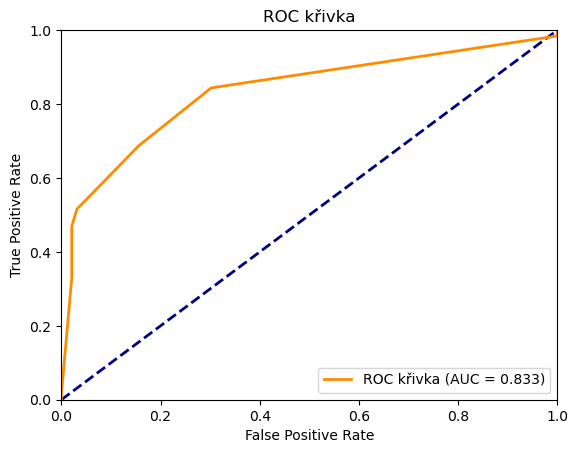

In [94]:
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
ax.plot(fpr, tpr, color="darkorange", lw=2, label = f"ROC křivka (AUC = {auc:.3f})")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC křivka")
ax.legend(loc="lower right")

### Evaluace

# 4. Final Results

- zvolit finalni nejlepsi model
- odhadnout presnost na novych datech (testovacich)
- napocitat predikce z evaluation.csv
- ulozit do results.csv